In [1]:
import os
import re
import gc

import numpy as np
import pandas as pd
import xarray as xr

import cftime
import pop_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature

import cmocean.cm as cmo
import matplotlib.ticker as ticker
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

ccrs = cartopy.crs
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

In [18]:
# Define configurations and paths
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/ensemble_mean/'

grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6]}}],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}
    ]
}
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')
    
def replace_invalid_T_values(ds, replacement_value=0):
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )
    return ds

In [6]:
def linear_regression(x, y):
    """ Perform linear regression and return the slope. Handle missing values. """
    # Ensure we only use valid (finite) points
    valid_mask = np.isfinite(y)
    if np.sum(valid_mask) < 2:  # We need at least two points to fit a line
        return np.nan  # Return NaN if there's not enough valid data
    p = np.polyfit(x[valid_mask], y[valid_mask], 1)
    return p[0]  # Return the slope coefficient

In [19]:
file = 'ensemble_mean_shf.nc'
ds = xr.open_dataset(path+file).isel(time=slice(0,160*12)).where(mask3d==1)

In [20]:
# Time variable
time = ds['time']
time_nums = np.arange(len(time))

# Apply the regression over time for each spatial location
regression_coefs = xr.apply_ufunc(
    linear_regression,  # Function to apply
    time_nums,  # x (independent variable)
    #ds.TEMP.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t'), 
    ds.SHF,  # y (dependent variable)
    vectorize=True,  # Allow vectorized operations
    input_core_dims=[['time'], ['time']],  # Specify core dimensions
    output_core_dims=[[]],  # Output is scalar for each point
    exclude_dims=set(('time',))  # Exclude time from the reduction
)

In [21]:
plotting_data = replace_invalid_T_values(regression_coefs)

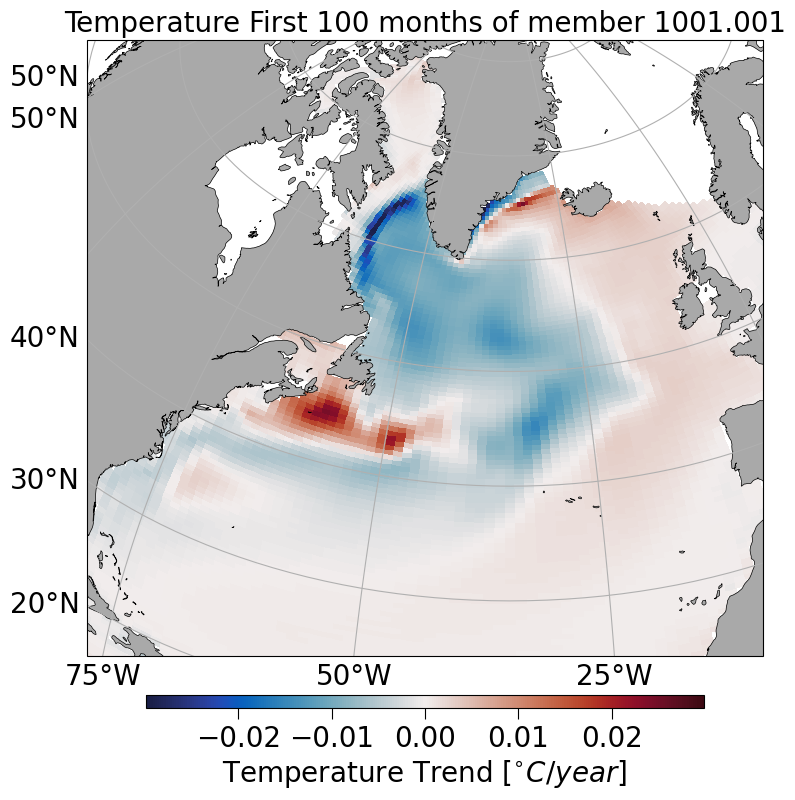

In [22]:
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':'Temperature Trend [$^{\circ}C/year$]', 'pad': 0.05}
vmin = -0.8
labelsize = 20

plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap=cmo.balance,
                                    #vmin = vmin, vmax = -vmin, 
                                    )
                                    
pc.colorbar.ax.xaxis.label.set_size(labelsize)
pc.colorbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

ax.add_feature(nature_coast);
#ax.coastlines()
plt.title('Temperature First 100 months of member 1001.001', fontsize=labelsize)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Test_Temperature_Trend.png', bbox_inches='tight', dpi=300)